In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt


In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')
print(merged_kin_df.shape[0], 'data points post-merge')

378 total WT RuBisCOs
304 total unique species
208 RuBisCOs with all core kinetic data measured
305 data points post-merge


In [4]:
# vC vs S
vCs = np.log(merged_kin_df.vC)
Ss = np.log(merged_kin_df.S)

print('Whole dataset correlation')
r, p = power_laws.log_pearsonr(Ss, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(Ss, vCs))

fIs = merged_kin_df[merged_kin_df.isoform == '1']
vCs = np.log(fIs.vC)
Ss = np.log(fIs.S)

print('FI dataset correlation')
r, p = power_laws.log_pearsonr(Ss, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(Ss, vCs))

vCs = np.log(savir_df.vC)
Ss = np.log(savir_df.S)

print('Savir correlation')
r, p = power_laws.log_pearsonr(Ss, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(Ss, vCs))

Whole dataset correlation
Log-scale linear regression R = 0.03, P = 0.68
Spearman rank correlation R = -0.32, P = 1.7e-06
FI dataset correlation
Log-scale linear regression R = -0.56, P = 8.4e-19
Spearman rank correlation R = -0.38, P = 1.3e-08
Savir correlation
Log-scale linear regression R = -0.71, P = 0.00072
Spearman rank correlation R = -0.88, P = 4.8e-07


In [5]:
# Central correlation of Tcherkez2006 is S vs vC. 
# Plot data from Savir separate from new data.

# S vs. vC correlation for all data rubiscos
Ss = np.log(merged_kin_df.S)
vCs = np.log(merged_kin_df.vC)
exponent, prefactor, r2 = power_laws.fit_power_law_odr(Ss, vCs)

# S vs. vC correlation for all data rubiscos
Ss_savir = np.log(savir_df.S)
vCs_savir = np.log(savir_df.vC)
exp_sav, pre_sav, r2_sav = power_laws.fit_power_law_odr(Ss_savir, vCs_savir)

In [6]:
all_FIs = merged_kin_df[merged_kin_df.isoform == '1']
exps, pres, rs = power_laws.bootstrap_power_law_odr(
    all_FIs.S, all_FIs.vC, fraction=0.9, rounds=10000)

conf_range = [2.5, 97.5]
pre_interval = np.percentile(pres, conf_range)
exp_interval = np.percentile(exps, conf_range)
rs_interval = np.percentile(rs, conf_range)

print(exp_interval)
print(pre_interval)
print(rs_interval)
print()

[-4.04032903 -2.01505562]
[3.08356487e+04 2.93430739e+08]
[0.38455006 0.69099546]



[3.08356487e+04 2.93430739e+08]
[-4.04032903 -2.01505562]


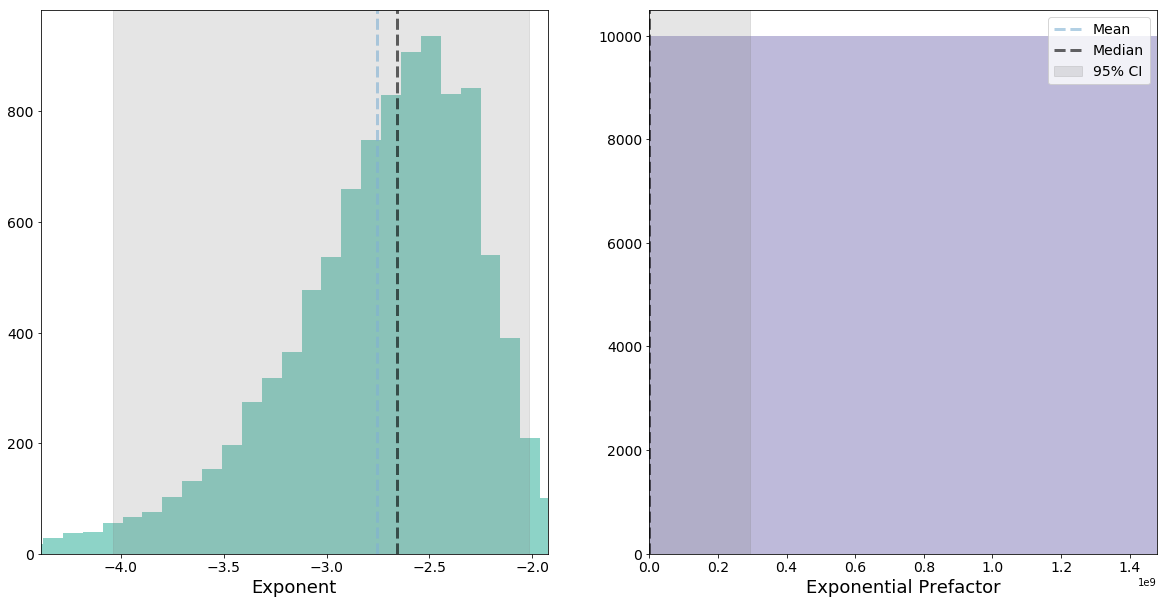

In [7]:
power_laws.plot_bootstrapped_range(exps, pres)

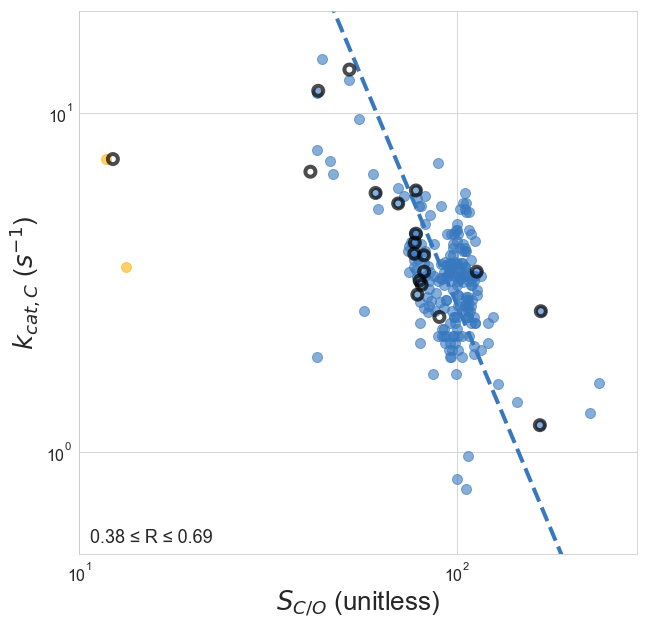

In [8]:
# Plot S vs. Vc coloring by RuBisCO form.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group == '3':
        continue
        
    label = 'Form %s' % groups[group]
    c = named_colors[i]
    plt.scatter(gdf.S, gdf.vC, c=[c], s=100, label=label, alpha=0.6)


# Plot regression of S vs vC
all_FIs = merged_kin_df[merged_kin_df.isoform == '1']
c = matplotlib.colors.rgb2hex(named_colors[0])
xs = np.arange(10, 300, 1)
power_laws.plot_bootstrapped_ci(xs, exps, pres, figure=figure, color=c, plot_range=False, lw=4)

# Show savir data with an outline
plt.scatter(savir_df.S, savir_df.vC, c='None', edgecolors='k',
            linewidths=4, s=100, label='Savir 2010', alpha=0.7, zorder=10)

#plt.legend(loc=1, fontsize=18, frameon=True)
plt.xlabel('$S_{C/O}$ (unitless)', fontsize=26)
plt.ylabel('$k_{cat,C}$ ($s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.text(0.02, 0.02, u'%.2f ≤ R ≤ %.2f' % (rs_interval[0], rs_interval[1]), 
         transform=figure.axes[0].transAxes, fontsize=18)

plt.xlim(10, 300)
plt.ylim(5e-1, 20)

plt.savefig('fig4/fig4_kcatC_S_corr_FI.svg')
plt.savefig('fig4/fig4_kcatC_S_corr_FI.png', dpi=600)

plt.show()

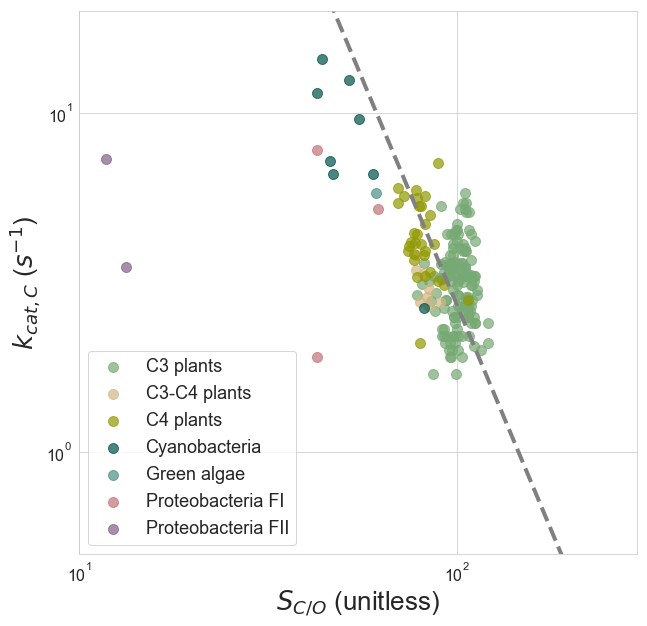

In [9]:
# Plot S vs. Vc coloring by RuBisCO form.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

F1_data = merged_kin_df[merged_kin_df.isoform == '1']
F2_data = merged_kin_df[merged_kin_df.isoform == '2']

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'C3-C4 plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Green algae': 'Green algae',
                 'Non-green algae': 'Non-green algae',
                 'Alphaproteobacteria': 'Proteobacteria FI',
                 'Betaproteobacteria': 'Proteobacteria FI',
                 'Gammaproteobacteria': 'Proteobacteria FI',
                }
color_mapping = {
    'C3 plants': 'dusty green',
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Non-green algae': 'dusty red',
    'Proteobacteria FI': 'dusty rose',
}

grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)

for i, (group, gdf) in enumerate(grouped_taxa):
    cname = color_mapping[group]
    c = seaborn.xkcd_rgb[cname]
    plt.scatter(gdf.S, gdf.vC, c=c, s=100, label=group, alpha=0.7)

f2_color = 'dusty purple'
c = seaborn.xkcd_rgb[f2_color]
plt.scatter(F2_data.S, F2_data.vC, c=c, s=100, label='Proteobacteria FII', alpha=0.7)
    
# Plot regression of S vs vC
xs = np.arange(10, 300, 1)
power_laws.plot_bootstrapped_ci(xs, exps, pres, figure=figure, color='grey', plot_range=False, lw=4)

plt.legend(loc=3, fontsize=18, frameon=True)
plt.xlabel('$S_{C/O}$ (unitless)', fontsize=26)
plt.ylabel('$k_{cat,C}$ ($s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(10, 300)
plt.ylim(5e-1, 20)

plt.savefig('fig4/fig4_kcatC_S_corr_FI_by_group.svg')
plt.savefig('fig4/fig4_kcatC_S_corr_FI_by_group.png', dpi=600)

plt.show()

In [10]:
# vC vs KC
vCs = np.log(merged_kin_df.vC)
KCs = np.log(merged_kin_df.KC)

print('Whole dataset correlation')
r, p = power_laws.log_pearsonr(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))

fIs = merged_kin_df[merged_kin_df.isoform == '1']
vCs = np.log(fIs.vC)
KCs = np.log(fIs.KC)

print('FI dataset correlation')
r, p = power_laws.log_pearsonr(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))

vCs = np.log(savir_df.vC)
KCs = np.log(savir_df.KC)

print('Savir correlation')
r, p = power_laws.log_pearsonr(KCs, vCs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(KCs, vCs))

Whole dataset correlation
Log-scale linear regression R = 0.35, P = 2.3e-08
Spearman rank correlation R = 0.44, P = 8.3e-13
FI dataset correlation
Log-scale linear regression R = 0.48, P = 4.3e-15
Spearman rank correlation R = 0.48, P = 4.7e-15
Savir correlation
Log-scale linear regression R = 0.92, P = 2.9e-08
Spearman rank correlation R = 0.86, P = 2e-06


In [11]:
all_FIs = merged_kin_df[merged_kin_df.isoform == '1']
exps, pres, rs = power_laws.bootstrap_power_law_odr(
    all_FIs.KC, all_FIs.vC, fraction=0.9, rounds=10000)

conf_range = [2.5, 97.5]
pre_interval = np.percentile(pres, conf_range)
exp_interval = np.percentile(exps, conf_range)
rs_interval = np.percentile(rs, conf_range)

print(exp_interval)
print(pre_interval)
print(rs_interval)
print()

[0.25375298 0.49858961]
[0.79513679 1.53259379]
[0.27048148 0.65609672]



[0.79513679 1.53259379]
[0.25375298 0.49858961]


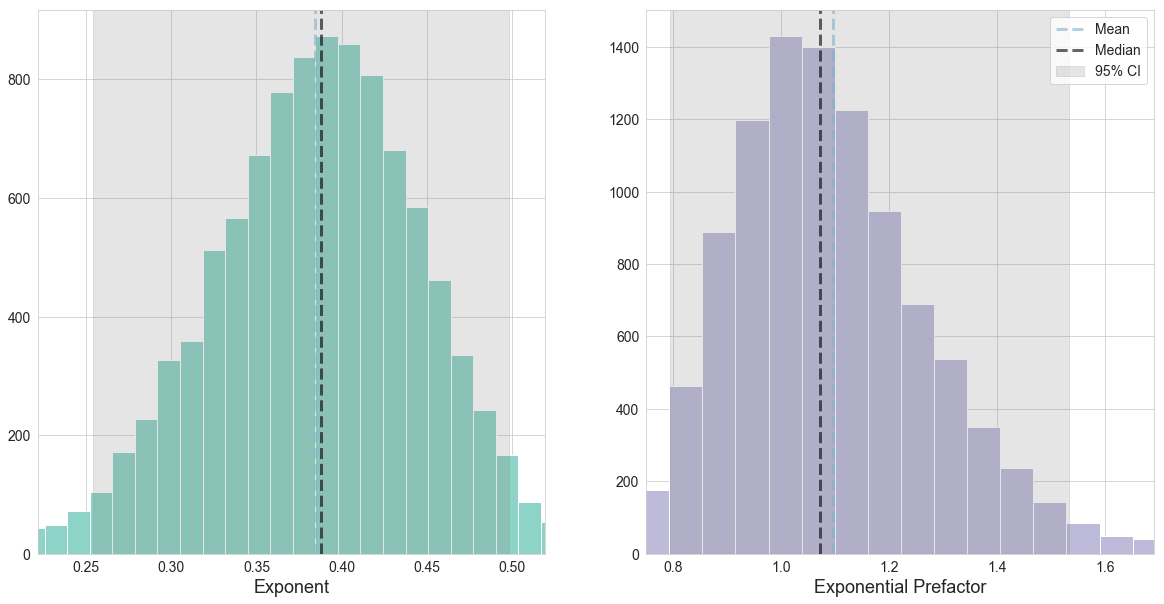

In [12]:
power_laws.plot_bootstrapped_range(exps, pres)

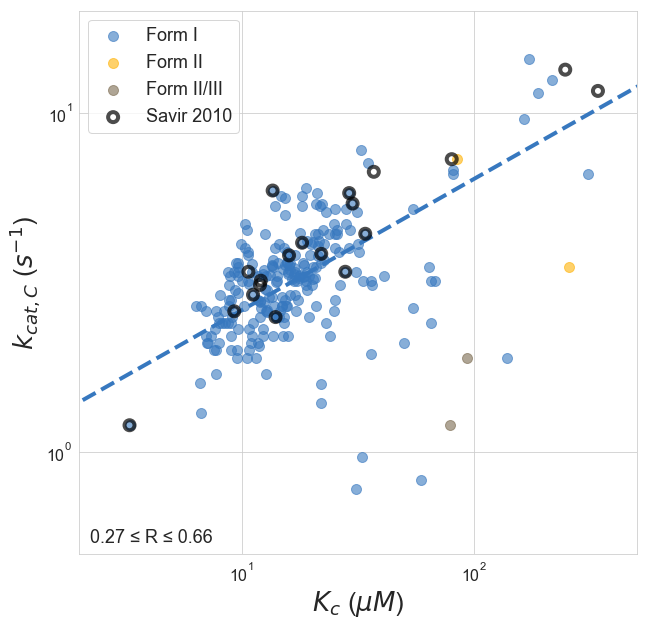

In [13]:
# Plot Kc vs. Vc coloring by RuBisCO form.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group == '3':
        continue
    
    label = 'Form %s' % groups[group]
    c = named_colors[i]
    plt.scatter(gdf.KC, gdf.vC, color=[c], s=100, label=label, alpha=0.6)

# Plot our own regression and CI - removed for now til I fix the plotting
xs = np.arange(1e0, 1e3, 0.01)
c = matplotlib.colors.rgb2hex(named_colors[0])
power_laws.plot_bootstrapped_ci(xs, exps, pres, figure=figure, color=c, plot_range=False, lw=4)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
#plt.plot(xs, projected_Vcs, ls='--', c='grey', lw=2)

# Show savir data with an outline
plt.scatter(savir_df.KC, savir_df.vC, c='None', edgecolors='k',
            linewidths=4, s=100, label='Savir 2010', alpha=0.7, zorder=10)

plt.text(0.02, 0.02, u'%.2f ≤ R ≤ %.2f' % (rs_interval[0], rs_interval[1]), 
         transform=figure.axes[0].transAxes, fontsize=18)

plt.legend(loc=2, fontsize=18, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=26)
plt.ylabel('$k_{cat,C}$ ($s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(5e-1, 20)
plt.xlim(2, 5e2)

plt.savefig('fig4/fig4_kcatC_KC_corr_FI.svg')
plt.savefig('fig4/fig4_kcatC_KC_corr_FI.png', dpi=600)

plt.show()